<a href="https://colab.research.google.com/github/Dhanushpugazh/ChickenDiseasePrediction/blob/main/demo_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'

!kaggle datasets download -d allandclive/chicken-disease-1

!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/healthy.1867.jpg  
  inflating: Train/healthy.1868.jpg  
  inflating: Train/healthy.1869.jpg  
  inflating: Train/healthy.187.jpg   
  inflating: Train/healthy.1870.jpg  
  inflating: Train/healthy.1871.jpg  
  inflating: Train/healthy.1872.jpg  
  inflating: Train/healthy.1873.jpg  
  inflating: Train/healthy.1874.jpg  
  inflating: Train/healthy.1875.jpg  
  inflating: Train/healthy.1876.jpg  
  inflating: Train/healthy.1877.jpg  
  inflating: Train/healthy.1878.jpg  
  inflating: Train/healthy.1879.jpg  
  inflating: Train/healthy.188.jpg   
  inflating: Train/healthy.1880.jpg  
  inflating: Train/healthy.1881.jpg  
  inflating: Train/healthy.1882.jpg  
  inflating: Train/healthy.1883.jpg  
  inflating: Train/healthy.1884.jpg  
  inflating: Train/healthy.1885.jpg  
  inflating: Train/healthy.1886.jpg  
  inflating: Train/healthy.1887.jpg  
  inflating: Train/healthy.1888.jpg  
  inflating: Train/healthy.1889.jpg  

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)
warnings.simplefilter("ignore")

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('Gpu not found')
# print('Found GPU at: {} '.format(device_name))

In [ ]:
sdir='/content/Train'
filepaths=[]
labels=[]
ht=0
wt=0
samples=0
sample_count=100
flist=os.listdir(sdir)
for i, f in enumerate(flist):
    fpath=os.path.join(sdir,f)
    filepaths.append(fpath)
    klass=f.split('.')[0]
    labels.append(klass)
    if i < sample_count:
        img=plt.imread(fpath)
        ht += img.shape[0]
        wt += img.shape[1]
        samples +=1
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
# split df into a train_df a valid_df and a test_df
trsplit=.9
vsplit=.05
dsplit =vsplit/(1-trsplit)
strat=df['labels']
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=strat)
strat=dummy_df['labels']
test_df, valid_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
classes=list(train_df['labels'].unique())
class_count = len(classes)
groups=df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)
      samples=len(group)
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
wave=wt/samples
have=ht/samples
aspect_ratio= have/wave
print ('Average Image Height: ' ,have, '  Average Image Width: ', wave, '  Aspect ratio: ', aspect_ratio)

train_df lenght:  7260   test_df length:  403   valid_df length:  404
            CLASS               IMAGE COUNT 
           pcrsalmo                 349     
           healthy                 2057     
            salmo                  2276     
            cocci                  2103     
           pcrcocci                 373     
             ncd                    376     
          pcrhealthy                347     
            pcrncd                  186     
Average Image Height:  120.43010752688173   Average Image Width:  120.43010752688173   Aspect ratio:  1.0


In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[]
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique()))
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [ ]:
max_samples=300
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)

Original Number of classes in dataframe:  8
[300, 300, 300, 300, 300, 300, 300, 168]


In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)

    print (list(train_df['labels'].value_counts()) )
    return train_df

In [ ]:
working_dir=r'./'
img_size=(224,224)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  8
[300, 300, 300, 300, 300, 300, 300, 168]
Found 168 validated image filenames.
Total Augmented images created=  132
[300, 300, 300, 300, 300, 300, 300, 300]


In [ ]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (128, 128) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 2400 validated image filenames belonging to 8 classes.
Found 404 validated image filenames belonging to 8 classes.
Found 403 validated image filenames belonging to 8 classes.
test batch size:  31   test steps:  13  number of classes :  8
       class name        class index 
          cocci               0      
         healthy              1      
           ncd                2      
        pcrcocci              3      
       pcrhealthy             4      
         pcrncd               5      
        pcrsalmo              6      
          salmo               7      


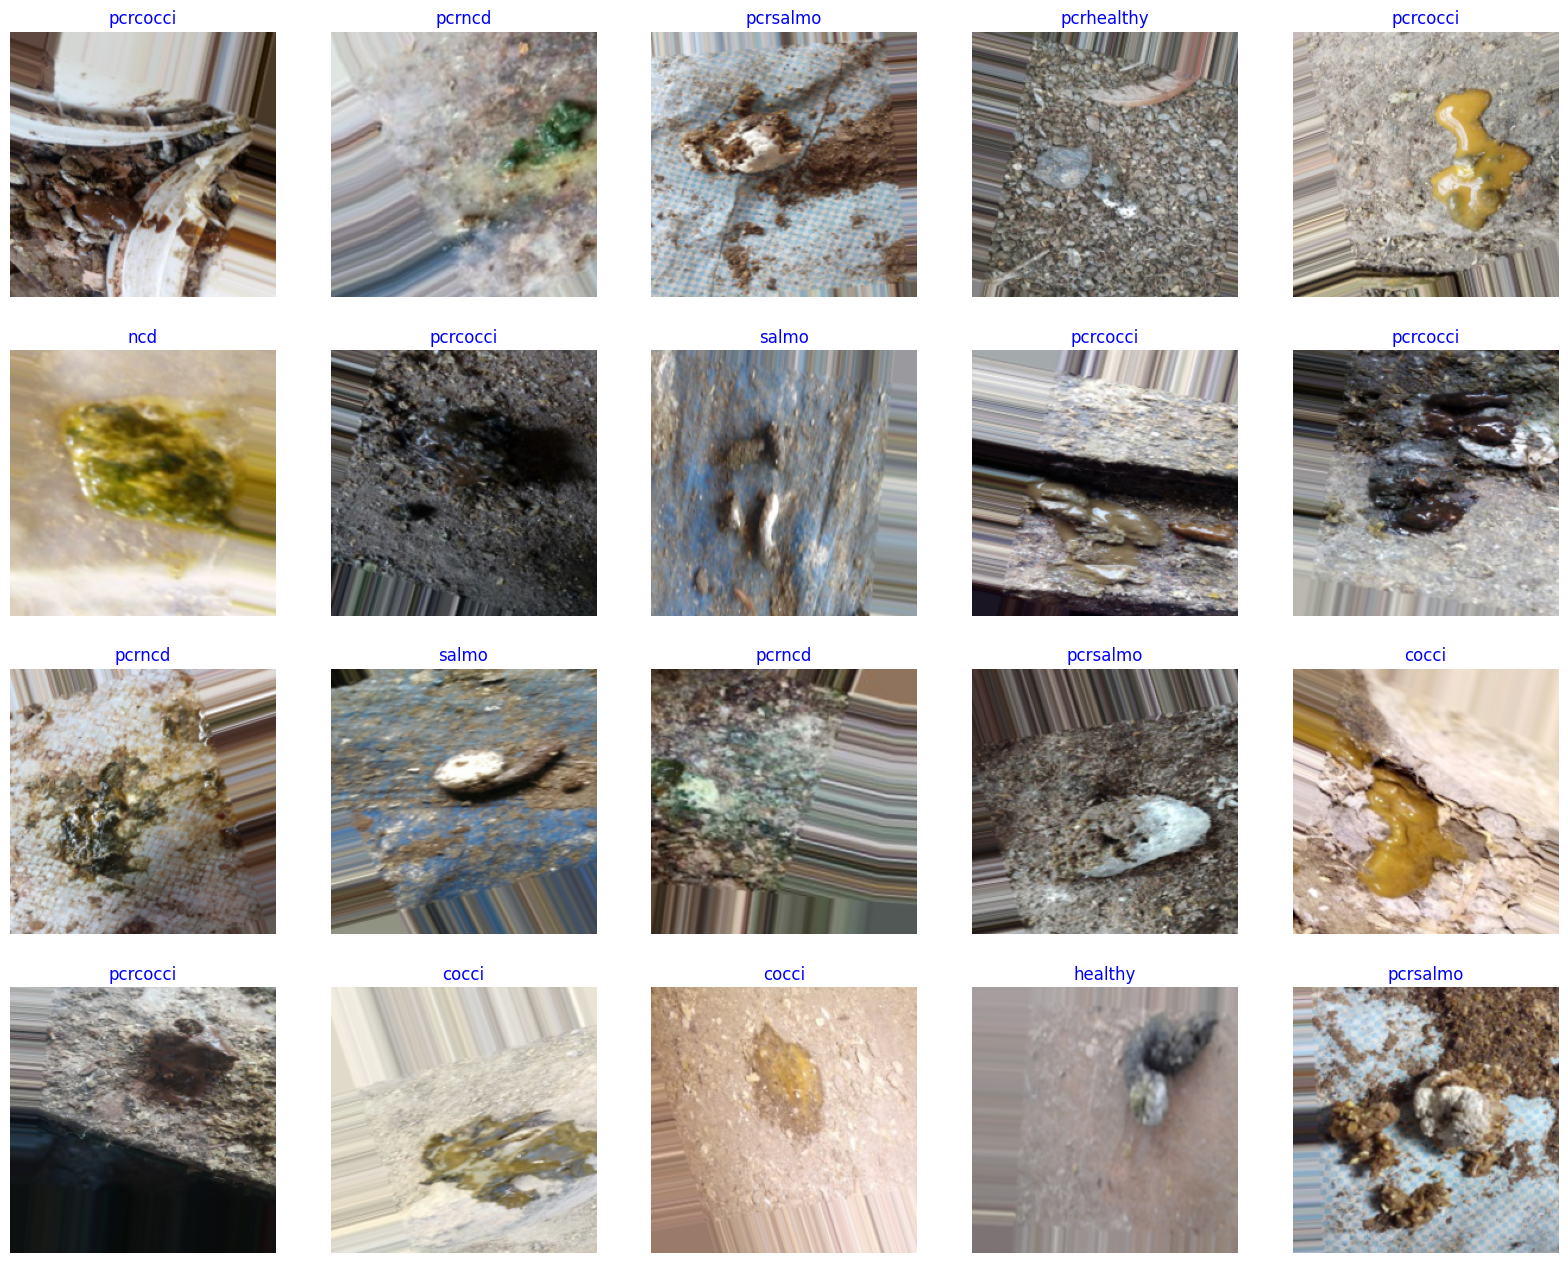

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [ ]:
#pip install --upgrade tensorflow

In [ ]:
#pip install tensorflow-addons

In [ ]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(2048, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)

x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model_1=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model_1.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

###########################################################################################################################

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetV2S'
base_model=EfficientNetV2S(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(2048, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)

x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model_2=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model_2.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

############################################################################################################################

img_shape=(img_size[0], img_size[1], 3)
model_name='ResNet50V2'
base_model=tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(2048, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)

x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model_3=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model_3.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

#####################################################################################################################



94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

class ASK(keras.callbacks.Callback):
    def __init__ (self, model_1, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model_1=model_1
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch

    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)


epochs=50
ask_epoch=50
ask=ASK(model_1, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)

# Define the ModelCheckpoint callback to save the model
checkpoint_filepath = '/content/drive/MyDrive/MODEL/best_model1.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)


callbacks = [rlronp, estop, ask, model_checkpoint_callback]


history=model_1.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

ask_epoch >= epochs, will train for  50  epochs
Training will proceed until epoch 50  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 29.1090 - accuracy: 0.5663
Epoch 1: val_loss improved from inf to 21.46379, saving model to /content/drive/MyDrive/MODEL/best_model1.hdf5
120/120 [==============================] - 131s 442ms/step - loss: 29.1090 - accuracy: 0.5663 - val_loss: 21.4638 - val_accuracy: 0.6832 - lr: 0.0010
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 16.3730 - accuracy: 0.7492
Epoch 2: val_loss improved from 21.46379 to 12.52855, saving model to /content/drive/MyDrive/MODEL/best_model1.hdf5
120/120 [==============================] - 49s 408ms/step - loss: 16.3730 - accuracy: 0.7492 - val_loss: 12.5285 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 

In [ ]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model_2, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model_2=model_2
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
    @tf.autograph.experimental.do_not_convert
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        model_save_path = os.path.join(self.save_dir, 'model_epoch_{}.h5'.format(epoch+1))
                        self.model_2.save(model_save_path)


epochs=50
ask_epoch=50
ask=ASK(model_2, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)

# Define the ModelCheckpoint callback to save the model
checkpoint_filepath = '/content/drive/MyDrive/MODEL/best_model2.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)


callbacks = [rlronp, estop, ask, model_checkpoint_callback]


history=model_2.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

ask_epoch >= epochs, will train for  50  epochs
Training will proceed until epoch 50  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 25.9188 - accuracy: 0.5546
Epoch 1: val_loss improved from inf to 18.92504, saving model to /content/drive/MyDrive/MODEL/best_model2.hdf5
120/120 [==============================] - 136s 441ms/step - loss: 25.9188 - accuracy: 0.5546 - val_loss: 18.9250 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 15.6312 - accuracy: 0.7229
Epoch 2: val_loss improved from 18.92504 to 12.17498, saving model to /content/drive/MyDrive/MODEL/best_model2.hdf5
120/120 [==============================] - 51s 421ms/step - loss: 15.6312 - accuracy: 0.7229 - val_loss: 12.1750 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 

In [ ]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model_3, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model_3=model_3
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
    @tf.autograph.experimental.do_not_convert
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time() # set the time at which training started

    def on_train_end(self, logs=None):   # runs at the end of training
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        model_save_path = os.path.join(self.save_dir, 'model_epoch_{}.h5'.format(epoch+1))
                        self.model_2.save(model_save_path)


epochs=50
ask_epoch=50
ask=ASK(model_3, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)

# Define the ModelCheckpoint callback to save the model
checkpoint_filepath = '/content/drive/MyDrive/MODEL/best_model3.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)


callbacks = [rlronp, estop, ask, model_checkpoint_callback]


history=model_3.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

ask_epoch >= epochs, will train for  50  epochs
Training will proceed until epoch 50  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 32.0283 - accuracy: 0.3092
Epoch 1: val_loss improved from inf to 700.79901, saving model to /content/drive/MyDrive/MODEL/best_model3.hdf5
120/120 [==============================] - 74s 356ms/step - loss: 32.0283 - accuracy: 0.3092 - val_loss: 700.7990 - val_accuracy: 0.2921 - lr: 0.0010
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 18.0172 - accuracy: 0.3175
Epoch 2: val_loss improved from 700.79901 to 16.35567, saving model to /content/drive/MyDrive/MODEL/best_model3.hdf5
120/120 [==============================] - 41s 336ms/step - loss: 18.0172 - accuracy: 0.3175 - val_loss: 16.3557 - val_accuracy: 0.5817 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss

In [ ]:
# subject='model1'
# acc=str(( 1-errors/tests) * 100)
# index=acc.rfind('.')
# acc=acc[:index + 3]
# save_id= subject + '_' + str(acc) + '.h5'
# working_dir = '/content/drive/MyDrive/MODELS'
# model_save_loc=os.path.join(working_dir, save_id)
# model_1.save_weights(model_save_loc)
# print ('model was saved as ' , model_save_loc )
# subject='model2'
# acc=str(( 1-errors/tests) * 100)
# index=acc.rfind('.')
# acc=acc[:index + 3]
# save_id= subject + '_' + str(acc) + '.h5'
# working_dir = '/content/drive/MyDrive/MODELS'
# model_save_loc=os.path.join(working_dir, save_id)
# model_2.save_weights(model_save_loc)
# print ('model was saved as ' , model_save_loc )


# model_1.save('/content/drive/MyDrive/MODEL/model1_4.21.h5')
# model_2.save('/content/drive/MyDrive/MODEL/model2_4.21.h5')
# model_2.save('/content/drive/MyDrive/MODEL/model3_4.21.h5')


In [ ]:
from tensorflow.keras.layers import Average
from tensorflow.keras.layers import Input

input_layer = Input(shape=img_shape)

output_1 = model_1(input_layer)
output_2 = model_2(input_layer)
output_3 = model_3(input_layer)


ensemble_output = Average()([output_1, output_2, output_3])

# Create the ensemble model with the averaged output layers
ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

# Compile the ensemble model
lr=.001 # start with this learning rate
ensemble_model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ensemble model
historynew = ensemble_model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


# from tensorflow.keras.layers import Average

# # Load the saved models
# model_1 = tf.keras.models.load_model('/kaggle/working/model1_4.21.h5')
# model_2 = tf.keras.models.load_model('/kaggle/working/model2_4.21.h5')

# # Define a new input layer for the ensemble model
# input_layer = tf.keras.layers.Input(shape=(img_size[0], img_size[1], 3))

# # Get the output of each base model
# output_1 = model_1(input_layer)
# output_2 = model_2(input_layer)

# # Take the average of the outputs
# ensemble_output = Average()([output_1, output_2])

# # Create the ensemble model
# ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=ensemble_output)

# # Compile the ensemble model
# lr=.001 # start with this learning rate
# ensemble_model.compile(tf.keras.optimizers.Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])


ask_epoch >= epochs, will train for  50  epochs
Training will proceed until epoch 50  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 1.2329 - accuracy: 0.9546
Epoch 1: val_loss did not improve from 0.59256
120/120 [==============================] - 295s 933ms/step - loss: 1.2329 - accuracy: 0.9546 - val_loss: 1.1289 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 0.9695 - accuracy: 0.9696
Epoch 2: val_loss did not improve from 0.59256
120/120 [==============================] - 109s 907ms/step - loss: 0.9695 - accuracy: 0.9696 - val_loss: 0.9488 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 0.9134 - accuracy: 0.9737
Epoch 3: val_loss did not improve from 0.59256
120/120 [==============================] - 107s 893ms/step - loss

In [ ]:
# ensemble_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

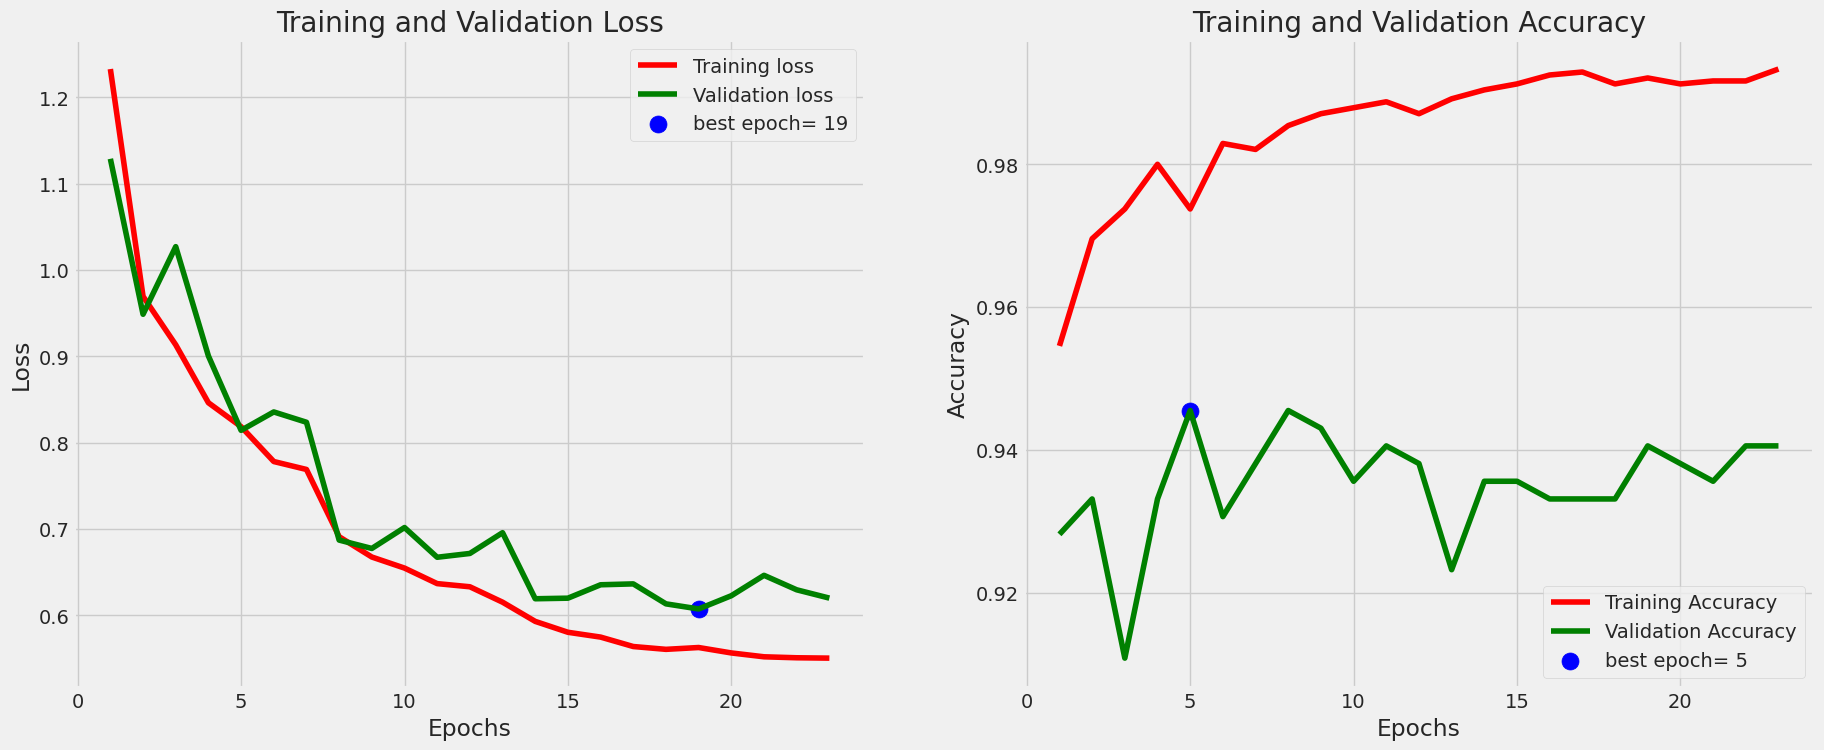

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(historynew,0)

13/13 [==============================] - 5s 129ms/step
there were 23 in 403 tests for an accuracy of  94.29


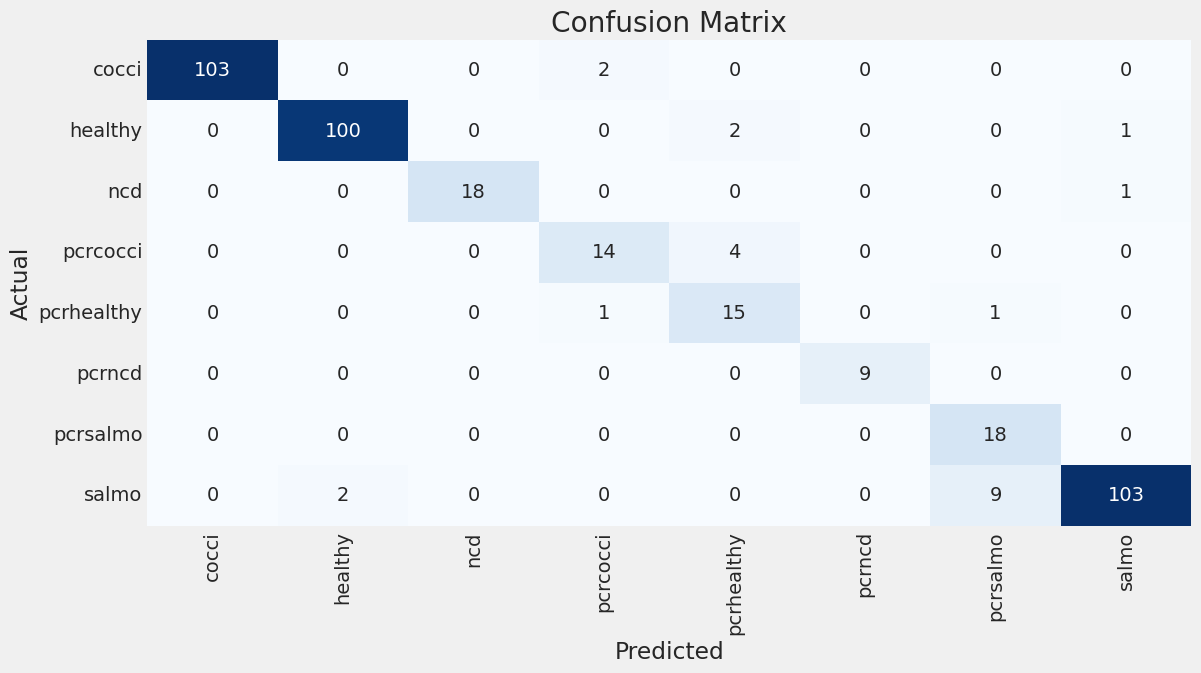

Classification Report:
----------------------
               precision    recall  f1-score   support

       cocci     1.0000    0.9810    0.9904       105
     healthy     0.9804    0.9709    0.9756       103
         ncd     1.0000    0.9474    0.9730        19
    pcrcocci     0.8235    0.7778    0.8000        18
  pcrhealthy     0.7143    0.8824    0.7895        17
      pcrncd     1.0000    1.0000    1.0000         9
    pcrsalmo     0.6429    1.0000    0.7826        18
       salmo     0.9810    0.9035    0.9406       114

    accuracy                         0.9429       403
   macro avg     0.8928    0.9329    0.9065       403
weighted avg     0.9537    0.9429    0.9457       403



In [ ]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model_1.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

13/13 [==============================] - 6s 129ms/step
there were 32 in 403 tests for an accuracy of  92.06


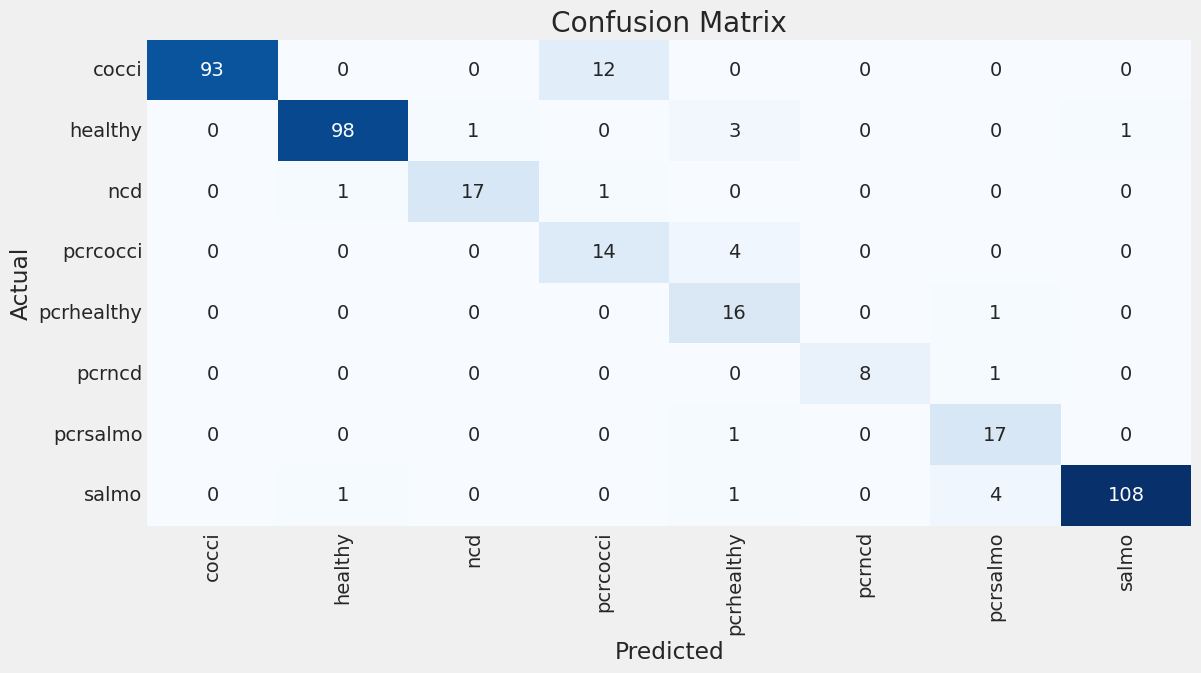

Classification Report:
----------------------
               precision    recall  f1-score   support

       cocci     1.0000    0.8857    0.9394       105
     healthy     0.9800    0.9515    0.9655       103
         ncd     0.9444    0.8947    0.9189        19
    pcrcocci     0.5185    0.7778    0.6222        18
  pcrhealthy     0.6400    0.9412    0.7619        17
      pcrncd     1.0000    0.8889    0.9412         9
    pcrsalmo     0.7391    0.9444    0.8293        18
       salmo     0.9908    0.9474    0.9686       114

    accuracy                         0.9206       403
   macro avg     0.8516    0.9039    0.8684       403
weighted avg     0.9413    0.9206    0.9268       403



In [ ]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model_2.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

13/13 [==============================] - 3s 78ms/step
there were 33 in 403 tests for an accuracy of  91.81


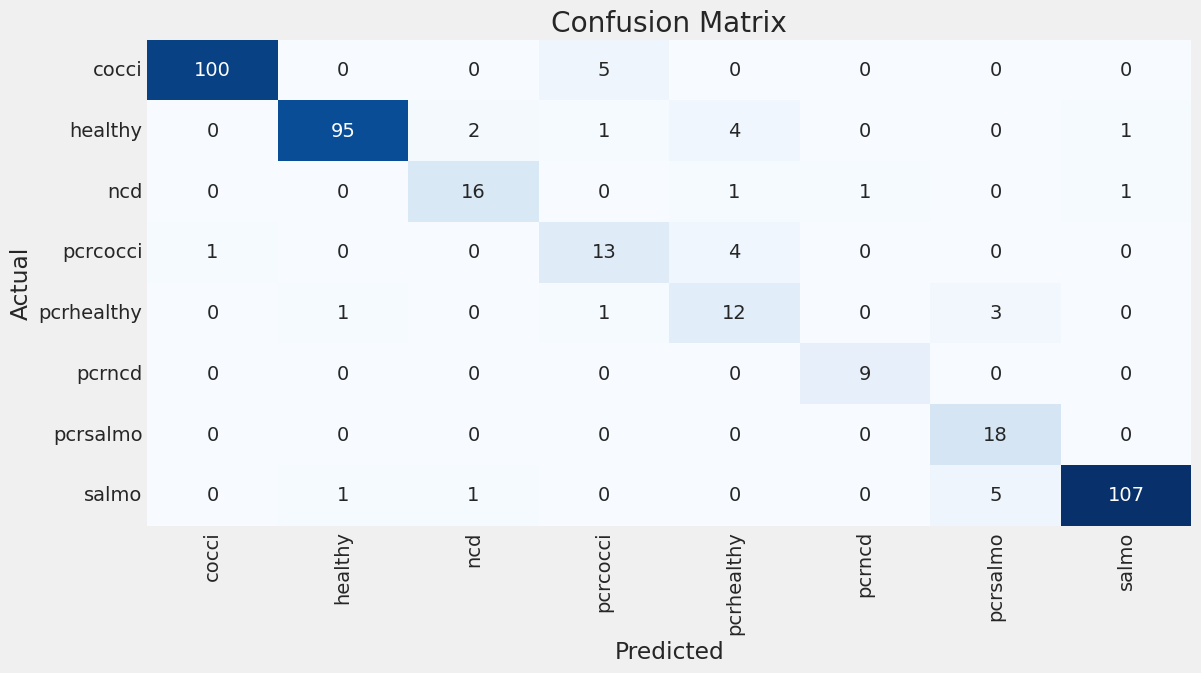

Classification Report:
----------------------
               precision    recall  f1-score   support

       cocci     0.9901    0.9524    0.9709       105
     healthy     0.9794    0.9223    0.9500       103
         ncd     0.8421    0.8421    0.8421        19
    pcrcocci     0.6500    0.7222    0.6842        18
  pcrhealthy     0.5714    0.7059    0.6316        17
      pcrncd     0.9000    1.0000    0.9474         9
    pcrsalmo     0.6923    1.0000    0.8182        18
       salmo     0.9817    0.9386    0.9596       114

    accuracy                         0.9181       403
   macro avg     0.8259    0.8854    0.8505       403
weighted avg     0.9298    0.9181    0.9218       403



In [ ]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=model_3.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

13/13 [==============================] - 11s 290ms/step
there were 19 in 403 tests for an accuracy of  95.29


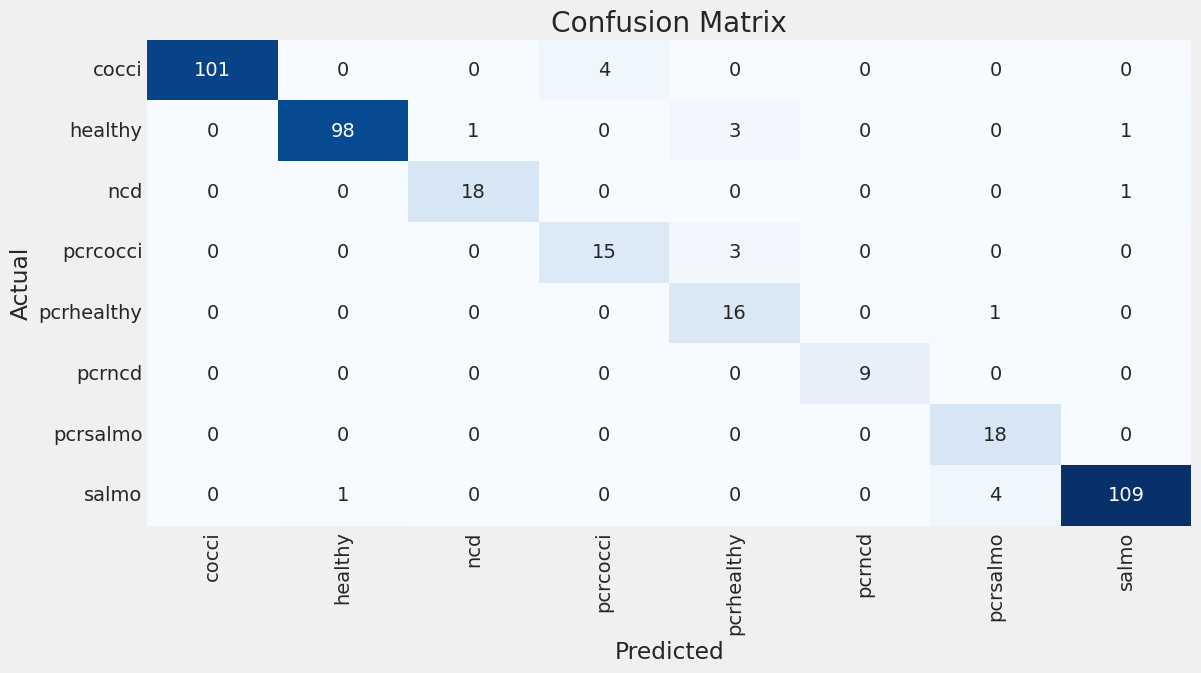

Classification Report:
----------------------
               precision    recall  f1-score   support

       cocci     1.0000    0.9619    0.9806       105
     healthy     0.9899    0.9515    0.9703       103
         ncd     0.9474    0.9474    0.9474        19
    pcrcocci     0.7895    0.8333    0.8108        18
  pcrhealthy     0.7273    0.9412    0.8205        17
      pcrncd     1.0000    1.0000    1.0000         9
    pcrsalmo     0.7826    1.0000    0.8780        18
       salmo     0.9820    0.9561    0.9689       114

    accuracy                         0.9529       403
   macro avg     0.9023    0.9489    0.9221       403
weighted avg     0.9592    0.9529    0.9546       403



In [ ]:
y_pred= []
y_true=test_gen.labels
errors=0
preds=ensemble_model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)